<Figure size 1000x600 with 0 Axes>

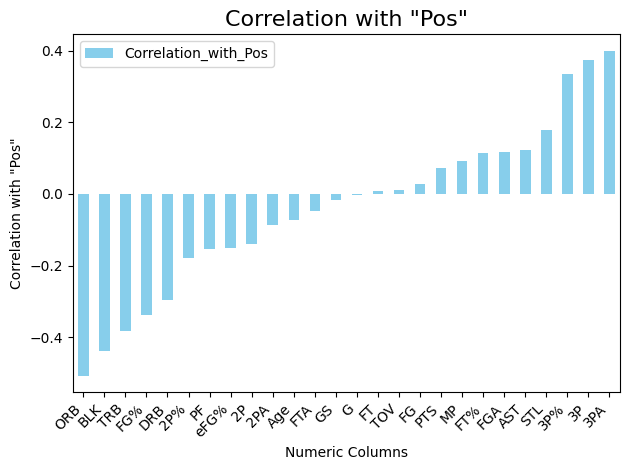



Training set accuracy: 0.7124463519313304


Validation set predictions:
['PG' 'C' 'PG' 'PG' 'C' 'PG' 'SG' 'SG' 'SG' 'SG' 'SG' 'PF' 'SG' 'PG' 'PF'
 'SG' 'PF' 'SG' 'SG' 'PF' 'PF' 'PF' 'PF' 'PG' 'PF' 'PG' 'C' 'SG' 'SG' 'PG'
 'SF' 'SF' 'PF' 'C' 'SG' 'SG' 'PF' 'SG' 'C' 'PF' 'PG' 'C' 'SG' 'SG' 'C'
 'SG' 'PF' 'PF' 'C' 'PF' 'SG' 'SF' 'PG' 'C' 'SF' 'C' 'PF' 'SF' 'SF' 'PF'
 'SG' 'PF' 'SG' 'C' 'PF' 'SG' 'PG' 'PG' 'SF' 'PG' 'PF' 'SF' 'SG' 'PF' 'SG'
 'C' 'PF' 'PF' 'PF' 'SF' 'C' 'SG' 'PF' 'PF' 'C' 'PF' 'PF' 'SF' 'PG' 'SF'
 'PF' 'SG' 'SG' 'SG' 'PF' 'SF' 'PF' 'SG' 'C' 'PF' 'PG' 'SG' 'SF' 'SF' 'C'
 'PG' 'C' 'PF' 'C' 'PF' 'PG' 'SF' 'PG' 'PG' 'C' 'PF' 'PG' 'C' 'C' 'SG'
 'PG' 'SG' 'C' 'PG' 'PF' 'SF' 'SG' 'PF' 'SG' 'C' 'PF' 'SG' 'SF' 'C' 'PG'
 'SG' 'SF' 'PG' 'SF' 'PG' 'C' 'PF' 'C' 'SG' 'PF' 'SF' 'PF' 'SF' 'PG' 'SG'
 'PG' 'C' 'SG' 'C' 'PG' 'C' 'SG' 'SG' 'PF' 'C' 'SF' 'SF' 'PF' 'SG' 'PF'
 'PG' 'SF' 'SF' 'PG' 'PF' 'PF' 'PG' 'SG' 'C' 'PG']

Validation set accuracy: 0.55


Confusion Matrix for Training Set
['

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd

# Get the current working directory
current_dir = os.getcwd()

# Construct the relative path to the CSV file
file_path = os.path.join(current_dir, 'nba_stats.csv')

# Load the dataset
df = pd.read_csv(file_path)

# Encode the 'Pos' column into numerical values
label_encoder = LabelEncoder()
df['Pos_encoded'] = label_encoder.fit_transform(df['Pos'])

# Select numeric columns only
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation of each numeric column with 'Pos'
correlation_with_pos = {}
for column in numeric_columns.columns:
    correlation_with_pos[column] = df[column].corr(df['Pos_encoded'])

# Convert dictionary to DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_with_pos, orient='index', columns=['Correlation_with_Pos'])

# Sort correlation values in ascending order
correlation_df_sorted = correlation_df.sort_values(by='Correlation_with_Pos')

# Plot the correlation values
plt.figure(figsize=(10, 6))
correlation_df_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation with "Pos"', fontsize=16)
plt.xlabel('Numeric Columns')
plt.ylabel('Correlation with "Pos"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Selecting feature column based on above correlation chart
class_column = 'Pos'
feature_columns = ['FG%', '3P%',  '2P%', 'FT%', 'eFG%' , 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
df_feature = df[feature_columns]
df_class = df[class_column]

# Standardize features
df_feature = pd.DataFrame(StandardScaler().fit_transform(df_feature))

# Split data into training and testing sets
train_feature, test_feature, train_class, test_class = train_test_split(df_feature, df_class, stratify=df_class, train_size=0.80, test_size=0.20)

# Create and train a Multi-Layer Perceptron classifier
model = MLPClassifier(hidden_layer_sizes=(30,), max_iter=500, alpha=0.001,
                      solver='adam', verbose=0,  random_state=1,
                      learning_rate_init=0.001)

model.fit(train_feature, train_class)
predict = model.predict(test_feature)

train_predict = model.predict(train_feature)
train_accuracy = accuracy_score(train_class, train_predict)
print("\n\nTraining set accuracy:", train_accuracy)

print("\n\nValidation set predictions:\n{}".format(predict))
print("\nValidation set accuracy: {:.2f}\n\n".format(model.score(test_feature, test_class)))


# Print confusion matrix for training set
print("Confusion Matrix for Training Set")
print("{}".format(train_class.unique()))
print(confusion_matrix(train_class, train_predict, labels=train_class.unique()))

# Print confusion matrix for validation set
print("\nConfusion Matrix for Validation Set")
print("{}".format(test_class.unique()))
print(confusion_matrix(test_class, predict, labels=test_class.unique()))

# Stratified Cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = []
for train_index, test_index in skf.split(df_feature, df_class):
    X_train, X_test = df_feature.iloc[train_index], df_feature.iloc[test_index]
    y_train, y_test = df_class.iloc[train_index], df_class.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

print("\n\nAccuracy in each Fold:\n{}".format(scores))  
print("\nAvg cross val score: {:.2f}\n\n".format(sum(scores)/10))

In [2]:
def test_model_with_new_data(test_def):
    # Get the current working directory
    current_dir = os.getcwd()

    # Construct the relative path to the CSV file
    file_path = os.path.join(current_dir, 'dummy_test.csv')

    # Load the dataset
    test_df = pd.read_csv(file_path)
    # Preprocess the test data
    test_df_feature = test_df[feature_columns]
    test_df_feature = pd.DataFrame(StandardScaler().fit_transform(test_df_feature))
    test_df_class = test_df[class_column]
    
    # Evaluate the model on the new test data
    test_accuracy = model.score(test_df_feature, test_df_class)
    predict = model.predict(test_df_feature)
    conf_matrix = confusion_matrix(test_df_class, list(predict), labels=test_df_class.unique())
    
    print("Test set predictions(Dummy_test):\n{}".format(predict))
    print("Test set accuracy(Dummy_test): {:.2f}\n\n".format(test_accuracy))
    print("Confusion Matrix")
    print("{}".format(test_df_class.unique()))
    print(conf_matrix)
    

# Example usage:
test_model_with_new_data('test_df')

Test set predictions(Dummy_test):
['PF' 'PF' 'SF' 'SG' 'SG' 'PF' 'SF' 'SG' 'PG' 'PG' 'SG' 'C' 'SG' 'SF' 'PG'
 'PG' 'PF' 'SF' 'PG' 'C' 'PG' 'SG' 'C' 'C' 'PF' 'PG' 'PG' 'PF' 'C' 'PG'
 'SG' 'C' 'SG' 'PF' 'SF' 'SG' 'PF' 'SF' 'PG' 'SG' 'PG' 'SF' 'SG' 'SF' 'PG'
 'PG' 'PF' 'C' 'SG' 'C' 'PG' 'PF' 'PF' 'SG' 'SF' 'C' 'SG' 'C' 'SG' 'PG'
 'SF' 'PF' 'PF' 'PG' 'SF' 'SG' 'PG' 'PF' 'PG' 'PF' 'SF' 'C' 'C' 'SG' 'PF'
 'PF' 'PF' 'SG' 'SG' 'SG' 'PF' 'SG' 'C' 'C' 'SG' 'SF' 'PF' 'PF']
Test set accuracy(Dummy_test): 0.73


Confusion Matrix
['PG' 'PF' 'SF' 'SG' 'C']
[[15  1  0  2  0]
 [ 2 12  1  2  2]
 [ 0  1 11  4  0]
 [ 1  3  1 14  0]
 [ 0  4  0  0 12]]
